In [1]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [2]:
from fl_mnist_implementation_utils import *

In [3]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        im_gray_resized = cv2.resize(im_gray, (48,69), interpolation = cv2.INTER_AREA)
        #image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(im_gray_resized/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

In [4]:
#declear path to your mnist data folder
img_path = r'D:\Important Files\Dataset Collection\Image Classification\Facial Expression\CK+ Modified'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=100)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=8)

[INFO] processed 100/2228
[INFO] processed 200/2228
[INFO] processed 300/2228
[INFO] processed 400/2228
[INFO] processed 500/2228
[INFO] processed 600/2228
[INFO] processed 700/2228
[INFO] processed 800/2228
[INFO] processed 900/2228
[INFO] processed 1000/2228
[INFO] processed 1100/2228
[INFO] processed 1200/2228
[INFO] processed 1300/2228
[INFO] processed 1400/2228
[INFO] processed 1500/2228
[INFO] processed 1600/2228
[INFO] processed 1700/2228
[INFO] processed 1800/2228
[INFO] processed 1900/2228
[INFO] processed 2000/2228
[INFO] processed 2100/2228
[INFO] processed 2200/2228


In [5]:
X_train = tf.stack(X_train)
y_train = tf.stack(y_train)
X_test = tf.stack(X_test)
y_test = tf.stack(y_test)

In [11]:
batch_size = 128
num_classes = 8
epochs = 60
input_shape = (69,48,1)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 48X48 with 1 byte color
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 256 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu',  kernel_initializer='he_uniform'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # 8 output neuron. It will contain a value from 0-7 for each classes
    tf.keras.layers.Dense(num_classes, activation='softmax')    
])


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 69, 48, 32)        832       
                                                                 
 batch_normalization_9 (Batc  (None, 69, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 48, 32)        25632     
                                                                 
 batch_normalization_10 (Bat  (None, 69, 48, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 24, 32)       0         
 2D)                                                             
                                                      

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
hist = model.fit(X_train, y_train, epochs = 75, batch_size = batch_size, validation_data=(X_test, y_test))

Epoch 1/75
16/16 [==============================] - 2s 64ms/step - loss: 3.1752 - accuracy: 0.1436 - val_loss: 4.0014 - val_accuracy: 0.1345
Epoch 2/75
16/16 [==============================] - 1s 53ms/step - loss: 2.7589 - accuracy: 0.1796 - val_loss: 3.7243 - val_accuracy: 0.1345
Epoch 3/75
16/16 [==============================] - 1s 53ms/step - loss: 2.5099 - accuracy: 0.1970 - val_loss: 2.7150 - val_accuracy: 0.1390
Epoch 4/75
16/16 [==============================] - 1s 53ms/step - loss: 2.3469 - accuracy: 0.2219 - val_loss: 2.3749 - val_accuracy: 0.1480
Epoch 5/75
16/16 [==============================] - 1s 53ms/step - loss: 2.1693 - accuracy: 0.2499 - val_loss: 2.1200 - val_accuracy: 0.2018
Epoch 6/75
16/16 [==============================] - 1s 53ms/step - loss: 2.0601 - accuracy: 0.2743 - val_loss: 2.7217 - val_accuracy: 0.1121
Epoch 7/75
16/16 [==============================] - 1s 53ms/step - loss: 1.9507 - accuracy: 0.3297 - val_loss: 2.9972 - val_accuracy: 0.1076
Epoch 8/75
16

Epoch 59/75
16/16 [==============================] - 1s 53ms/step - loss: 0.0551 - accuracy: 0.9845 - val_loss: 0.1648 - val_accuracy: 0.9731
Epoch 60/75
16/16 [==============================] - 1s 53ms/step - loss: 0.0504 - accuracy: 0.9855 - val_loss: 0.2063 - val_accuracy: 0.9552
Epoch 61/75
16/16 [==============================] - 1s 53ms/step - loss: 0.0416 - accuracy: 0.9880 - val_loss: 0.1436 - val_accuracy: 0.9641
Epoch 62/75
16/16 [==============================] - 1s 54ms/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 0.1504 - val_accuracy: 0.9596
Epoch 63/75
16/16 [==============================] - 1s 54ms/step - loss: 0.0599 - accuracy: 0.9835 - val_loss: 0.2136 - val_accuracy: 0.9552
Epoch 64/75
16/16 [==============================] - 1s 54ms/step - loss: 0.0482 - accuracy: 0.9865 - val_loss: 0.1444 - val_accuracy: 0.9641
Epoch 65/75
16/16 [==============================] - 1s 53ms/step - loss: 0.0345 - accuracy: 0.9900 - val_loss: 0.1974 - val_accuracy: 0.9641
Epoch 

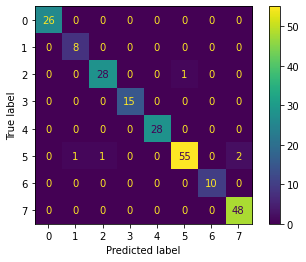

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred = model.predict(X_test)
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [16]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

y_pred_proba = model.predict(X_test)

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)       

ROC_AUC Score: 0.998671344941131
Cohen_Kappa Score: 0.9730200595252498
F1 Score: 0.9803509109790843
Matthews Correlation Coefficient: 0.9731861398163394
Log Loss: 0.15202224551325907
Accuracy: 0.9775784753363229


Text(0, 0.5, 'Loss')

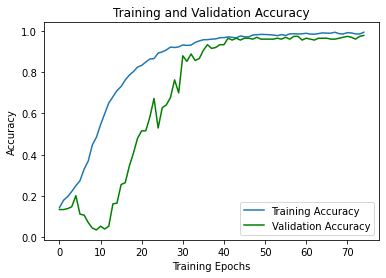

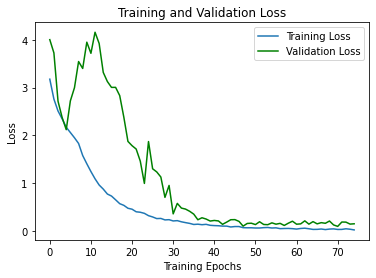

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = hist.history[     'accuracy' ]
val_acc  = hist.history[ 'val_accuracy' ]
loss     = hist.history[    'loss' ]
val_loss = hist.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.title ('Training and Validation Accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Training Epochs')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.title ('Training and Validation Loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
